In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from xgboost import XGBClassifier

from textblob import TextBlob


In [3]:
df = pd.read_csv("D:\Customer_support_data.csv")

print("Shape:", df.shape)
df.head()


<>:2: SyntaxWarning: invalid escape sequence '\C'
<>:2: SyntaxWarning: invalid escape sequence '\C'
C:\Users\ASUS\AppData\Local\Temp\ipykernel_20752\3730281091.py:2: SyntaxWarning: invalid escape sequence '\C'
  df = pd.read_csv("D:\Customer_support_data.csv")


Shape: (85907, 20)


,Unique id,channel_name,category,Sub-category,Customer Remarks,Order_id,order_date_time,Issue_reported at,issue_responded,Survey_response_Date,Customer_City,Product_category,Item_price,connected_handling_time,Agent_name,Supervisor,Manager,Tenure Bucket,Agent Shift,CSAT Score
0,7e9ae164-6a8b-4521-a2d4-58f7c9fff13f,Outcall,Product Queries,Life Insurance,NaN,c27c9bb4-fa36-4140-9f1f-21009254ffdb,NaN,01/08/2023 11:13,01/08/2023 11:47,01-Aug-23,NaN,NaN,NaN,NaN,Richard Buchanan,Mason Gupta,Jennifer Nguyen,On Job Training,Morning,5
1,b07ec1b0-f376-43b6-86df-ec03da3b2e16,Outcall,Product Queries,Product Specific Information,NaN,d406b0c7-ce17-4654-b9de-f08d421254bd,NaN,01/08/2023 12:52,01/08/2023 12:54,01-Aug-23,NaN,NaN,NaN,NaN,Vicki Collins,Dylan Kim,Michael Lee,>90,Morning,5
2,200814dd-27c7-4149-ba2b-bd3af3092880,Inbound,Order Related,Installation/demo,NaN,c273368d-b961-44cb-beaf-62d6fd6c00d5,NaN,01/08/2023 20:16,01/08/2023 20:38,01-Aug-23,NaN,NaN,NaN,NaN,Duane Norman,Jackson Park,William Kim,On Job Training,Evening,5
3,eb0d3e53-c1ca-42d3-8486-e42c8d622135,Inbound,Returns,Reverse Pickup Enquiry,NaN,5aed0059-55a4-4ec6-bb54-97942092020a,NaN,01/08/2023 20:56,01/08/2023 21:16,01-Aug-23,NaN,NaN,NaN,NaN,Patrick Flores,Olivia Wang,John Smith,>90,Evening,5
4,ba903143-1e54-406c-b969-46c52f92e5df,Inbound,Cancellation,Not Needed,NaN,e8bed5a9-6933-4aff-9dc6-ccefd7dcde59,NaN,01/08/2023 10:30,01/08/2023 10:32,01-Aug-23,NaN,NaN,NaN,NaN,Christopher Sanchez,Austin Johnson,Michael Lee,0-30,Morning,5


In [5]:
df['Issue_reported at'] = pd.to_datetime(df['Issue_reported at'], errors='coerce')
df['issue_responded'] = pd.to_datetime(df['issue_responded'], errors='coerce')

df['response_time'] = (df['issue_responded'] - df['Issue_reported at']).dt.total_seconds() / 60
df['response_time'] = df['response_time'].fillna(df['response_time'].median())

df['response_speed'] = pd.cut(df['response_time'],
                              bins=[-1,5,30,120,1e6],
                              labels=['Very Fast','Fast','Slow','Very Slow'])

tenure_map = {'On Job Training': 0, '0-30': 1, '30-60': 2, '60-90': 3, '>90': 4}
df['Tenure Bucket'] = df['Tenure Bucket'].map(tenure_map)

df['remarks_sentiment'] = df['Customer Remarks'].astype(str).apply(
    lambda x: TextBlob(x).sentiment.polarity if x != 'nan' else 0
)

df['Item_price'] = pd.to_numeric(df['Item_price'], errors='coerce').fillna(df['Item_price'].median())

df['CSAT_binary'] = df['CSAT Score'].apply(lambda x: 1 if x >= 4 else 0)


C:\Users\ASUS\AppData\Local\Temp\ipykernel_20752\4046431416.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='CSAT Score', data=df, hue=None, palette="viridis", legend=False)


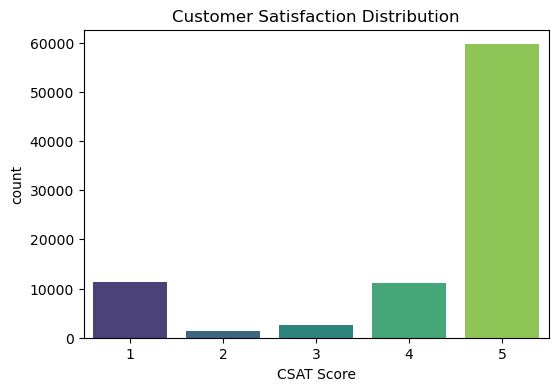

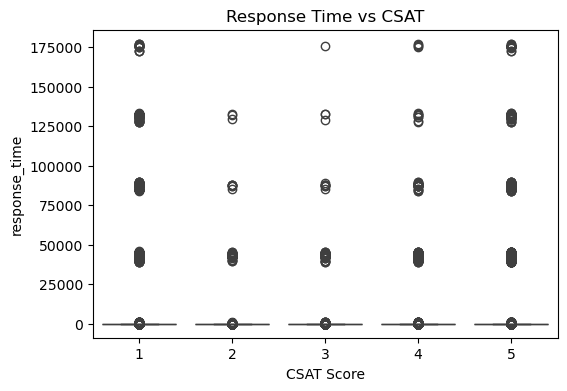

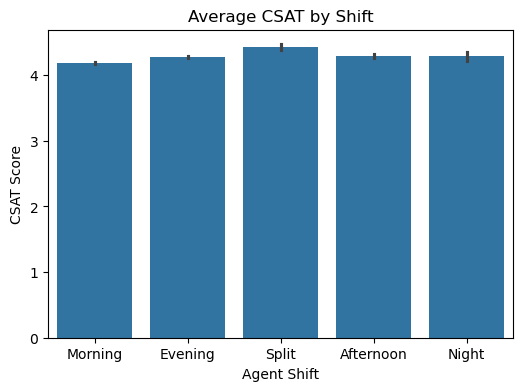

In [6]:
plt.figure(figsize=(6,4))
sns.countplot(x='CSAT Score', data=df, hue=None, palette="viridis", legend=False)
plt.title("Customer Satisfaction Distribution")
plt.show()

plt.figure(figsize=(6,4))
sns.boxplot(x='CSAT Score', y='response_time', data=df)
plt.title("Response Time vs CSAT")
plt.show()

plt.figure(figsize=(6,4))
sns.barplot(x='Agent Shift', y='CSAT Score', data=df, estimator=np.mean)
plt.title("Average CSAT by Shift")
plt.show()


In [7]:
categorical_cols = ['channel_name','category','Sub-category','Customer_City',
                    'Product_category','Agent_name','Supervisor','Manager',
                    'Agent Shift','response_speed']

df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

X = df.drop(['CSAT Score','CSAT_binary','Unique id','Order_id',
             'order_date_time','Survey_response_Date',
             'Issue_reported at','issue_responded','Customer Remarks'], axis=1)

y = df['CSAT_binary']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [8]:
param_grid = {
    'n_estimators': [300, 500],
    'learning_rate': [0.05, 0.1],
    'max_depth': [4, 6, 8],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

xgb = XGBClassifier(
    n_jobs=-1,       
    random_state=42,
    eval_metric="logloss"
)

grid = GridSearchCV(xgb, param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)

print("Best Parameters:", grid.best_params_)
print("Best CV Accuracy:", grid.best_score_)


Fitting 3 folds for each of 48 candidates, totalling 144 fits
Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 300, 'subsample': 0.8}
Best CV Accuracy: 0.8446271419445727


Test Accuracy: 0.8468164358049122

Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.18      0.29      2971
           1       0.85      0.99      0.91     14211

    accuracy                           0.85     17182
   macro avg       0.79      0.58      0.60     17182
weighted avg       0.83      0.85      0.81     17182



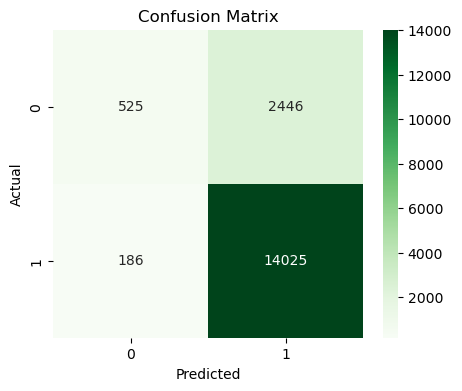

In [9]:
best_model = grid.best_estimator_

y_pred = best_model.predict(X_test)

print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

plt.figure(figsize=(5,4))
sns.heatmap(con
            fusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap="Greens")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
